In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance, plot_tree
import pandas as pd
import numpy as np
import xgboost

## Daten einlesen

In [3]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

### Features 

In [15]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

## Split

In [4]:
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')

data = data[data ['Open']!=0]
data = data[data ['Sales']>0]
#data = data[data ['StateHoliday']!=1]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

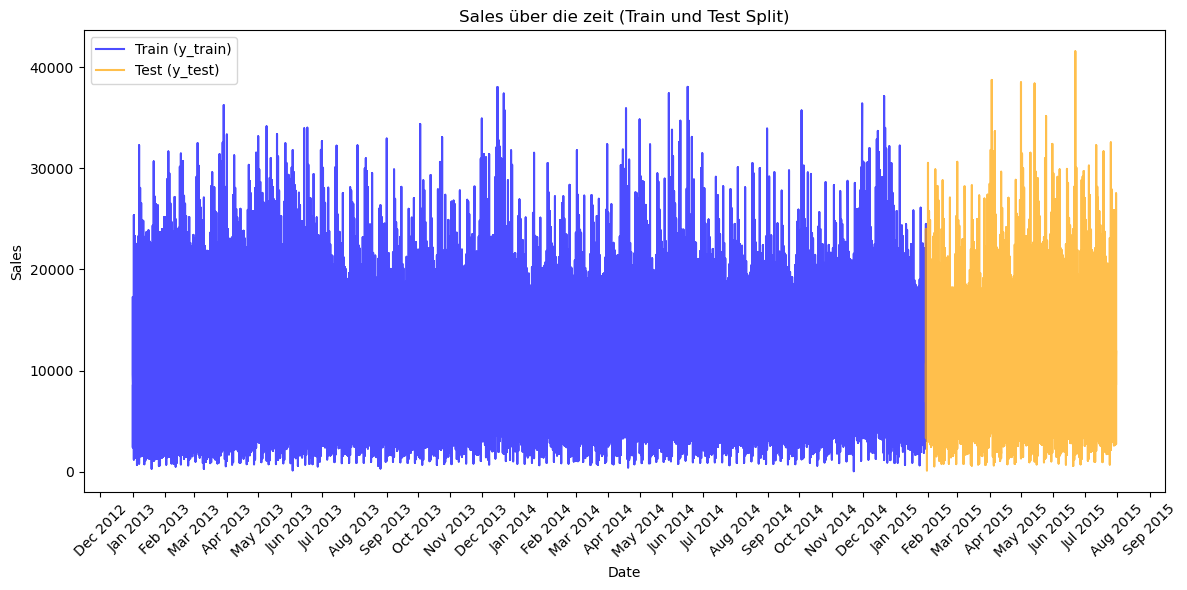

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Konvertiere die 'Date'-Spalte in datetime mit der .loc Methode
X_train.loc[:, 'Date'] = pd.to_datetime(X_train['Date'], errors='coerce')
X_test.loc[:, 'Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

# Liniendiagramm erstellen, um die wahren Sales in y_train und y_test zu visualisieren
plt.figure(figsize=(12, 6))

# Plot für die Trainingsdaten (y_train)
plt.plot(X_train['Date'], y_train, label='Train (y_train)', color='blue', alpha=0.7)

# Plot für die Testdaten (y_test)
plt.plot(X_test['Date'], y_test, label='Test (y_test)', color='orange', alpha=0.7)

# Achsenbeschriftungen
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales über die Zeit (Train und Test Split)')

# X-Achse mit Datumsformatierung (Monat und Jahr)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Drehe die x-Achsenbeschriftung für bessere Lesbarkeit

# Legende
plt.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

## Metrik

In [5]:

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [6]:
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung (TimeSeries)

In [7]:
from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

## Pre-processing

In [16]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

## XGBoost

In [17]:
import xgboost

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor())
])

In [18]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortm...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [19]:
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [20]:
cv_scores

array([-0.41794339, -0.33914783, -0.35268537, -0.31360045, -0.45600596])

In [21]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.3758766016105483

In [22]:
y_pred = pipeline_xgb.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.3383025676439931

## Feature Importance

In [24]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline_xgb.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline_xgb.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

Feature  Importance
1141  cat__Store_1114    0.013466
289    cat__Store_262    0.011925
844    cat__Store_817    0.010993
410    cat__Store_383    0.010700
589    cat__Store_562    0.010570
...               ...         ...
166    cat__Store_139    0.000000
761    cat__Store_734    0.000000
170    cat__Store_143    0.000000
751    cat__Store_724    0.000000
877    cat__Store_850    0.000000

[1143 rows x 2 columns]

In [25]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

Feature  Importance
1141       cat__Store_1114    0.013466
289         cat__Store_262    0.011925
844         cat__Store_817    0.010993
410         cat__Store_383    0.010700
589         cat__Store_562    0.010570
...                    ...         ...
4     num__fourier_sin_365    0.000024
13        cat__DayOfWeek_4    0.000023
12        cat__DayOfWeek_3    0.000021
11        cat__DayOfWeek_2    0.000019
139         cat__Store_112    0.000007

[1036 rows x 2 columns]

In [26]:
feature_importance_df[feature_importance_df['Importance'] == 0]

Feature  Importance
451  cat__Store_424         0.0
90    cat__Store_63         0.0
89    cat__Store_62         0.0
810  cat__Store_783         0.0
713  cat__Store_686         0.0
..              ...         ...
166  cat__Store_139         0.0
761  cat__Store_734         0.0
170  cat__Store_143         0.0
751  cat__Store_724         0.0
877  cat__Store_850         0.0

[107 rows x 2 columns]

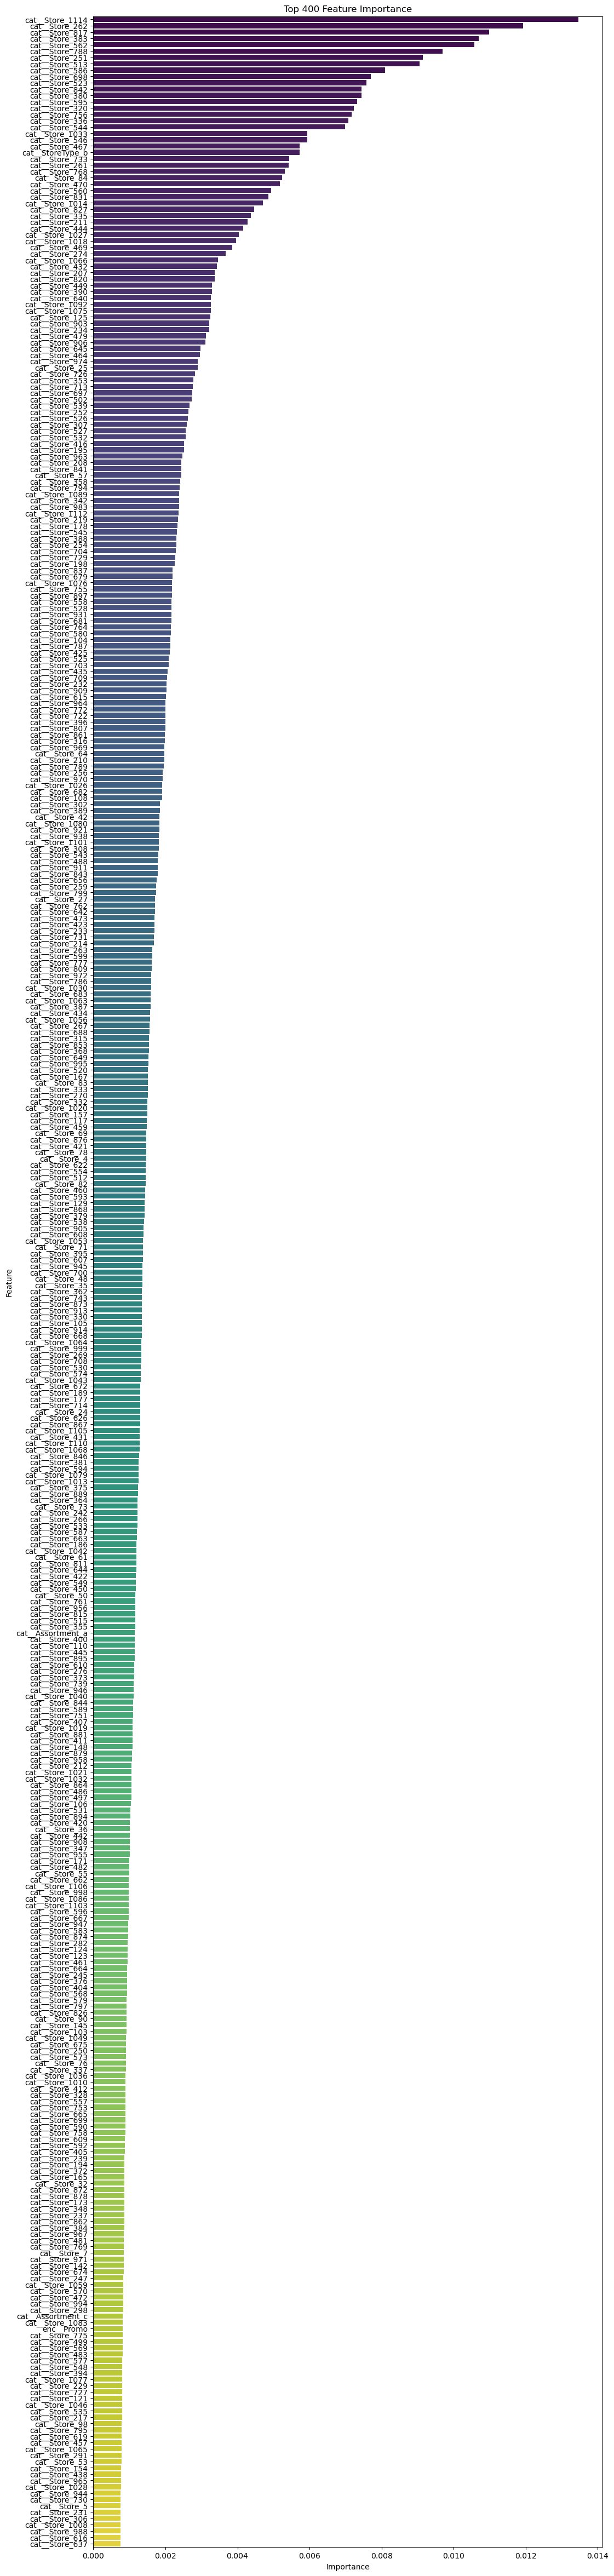

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:400]

# Setze die Größe der Abbildung
plt.figure(figsize=(12,60))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 400 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

## Hyperparameter Optimierung

### Optuna

In [32]:
import optuna
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import numpy as np

# Optuna-Objective-Funktion
def objective(trial):
    # Hyperparameter-Vorschläge durch Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 900),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        #'early_stopping_rounds': 50  # Early stopping für effizienteres Training
    }
    
    # XGBoost-Modell mit den vorgeschlagenen Parametern
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)

    # Erstelle die Pipeline mit dem Preprocessing und dem Modell
    pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
            ('model', model)   
    ])
    
    # Cross-Validation Score berechnen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)

    # Rückgabe des negativen Durchschnitts, da Optuna standardmäßig minimiert
    return -np.mean(cv_scores)

# Optuna-Studie erstellen und Optimierung starten
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())  # Pruner hinzugefügt
study.optimize(objective, n_trials=1000)

# Beste Ergebnisse anzeigen
print("Beste Parameter:", study.best_params)
print("Bester Wert (RMSPE):", study.best_value)

[I 2024-09-19 23:39:18,273] A new study created in memory with name: no-name-e354a574-ef94-4e8c-9d68-64cf2ce3ff8d
[I 2024-09-19 23:39:27,523] Trial 0 finished with value: 0.3449858854078026 and parameters: {'n_estimators': 183, 'max_depth': 8, 'min_child_weight': 9, 'learning_rate': 0.19905030354911354, 'subsample': 0.669326358389216, 'colsample_bytree': 0.6380515673753843, 'colsample_bylevel': 0.8023042626023913, 'gamma': 4.882532266457538, 'reg_alpha': 0.8664852089823155, 'reg_lambda': 8.064116430825486}. Best is trial 0 with value: 0.3449858854078026.
[I 2024-09-19 23:39:31,280] Trial 1 finished with value: 0.509184655648428 and parameters: {'n_estimators': 65, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.04630744016152754, 'subsample': 0.6923022402603697, 'colsample_bytree': 0.7740796817062834, 'colsample_bylevel': 0.5379533550580375, 'gamma': 3.8374514916999525, 'reg_alpha': 0.5153494719347641, 'reg_lambda': 2.1797651001111817}. Best is trial 0 with value: 0.344985885

Beste Parameter: {'n_estimators': 900, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.2688555222102847, 'subsample': 0.8049082697078238, 'colsample_bytree': 0.9017085061339981, 'colsample_bylevel': 0.9016501277919797, 'gamma': 3.5191228580676372, 'reg_alpha': 0.4301285235544994, 'reg_lambda': 5.1451545907615355}
Bester Wert (RMSPE): 0.22514420173203087


### Visualisierung

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Extrahiere die Parameter und die Zielwerte aus der Optuna-Studie
trials = study.trials_dataframe()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extrahiere die Parameter und die Zielwerte aus der Optuna-Studie
trials = study.trials_dataframe()

# Wähle relevante Parameter und das Ziel (Objective) aus
params = ['params_n_estimators', 'params_max_depth', 'params_learning_rate', 'params_subsample', 'params_colsample_bytree']
df = trials[params + ['value']]  # 'value' enthält die Objective-Werte (z.B. RMSPE)

# Erstelle eine parallele Koordinaten-Visualisierung
pd.plotting.parallel_coordinates(df, 'value', colormap='cool', alpha=0.3)
plt.title("Parallel Coordinates Plot für Optuna Trials")
plt.xlabel("Hyperparameters")
plt.ylabel("Objective Value (RMSPE)")
plt.show()

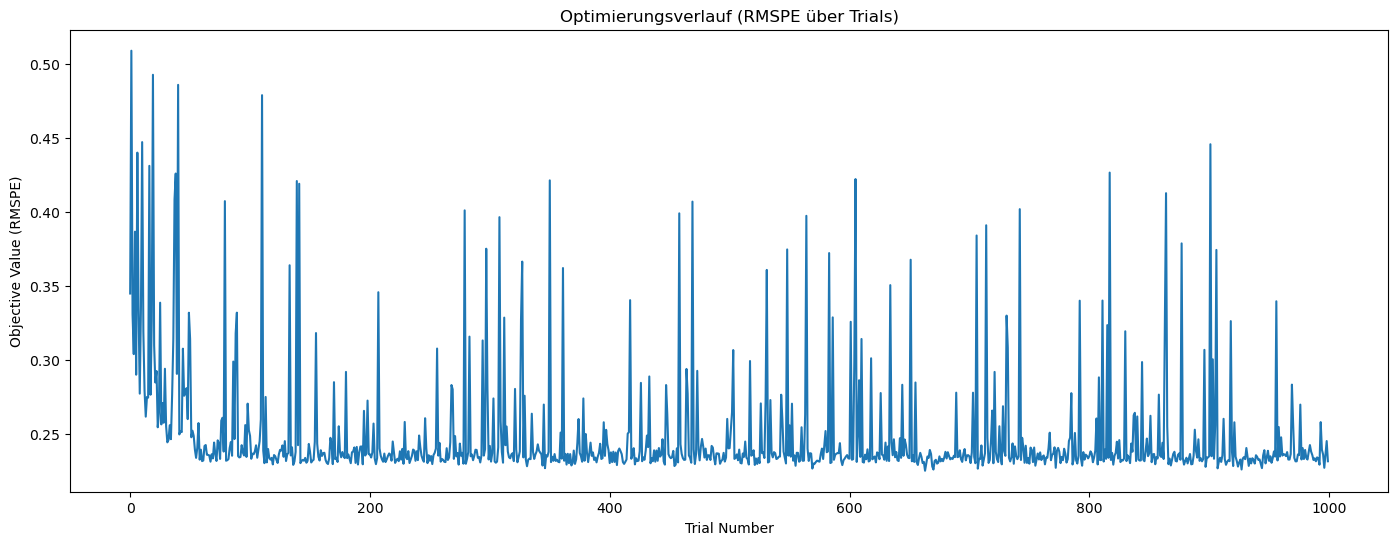

In [103]:
# Visualisiere den Verlauf der Optimierung
plt.figure(figsize=(17, 6))
plt.plot(trials['number'], trials['value'],  linestyle='-')
plt.xlabel('Trial Number')
plt.ylabel('Objective Value (RMSPE)')
plt.title('Optimierungsverlauf (RMSPE über Trials)')
plt.show()

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda

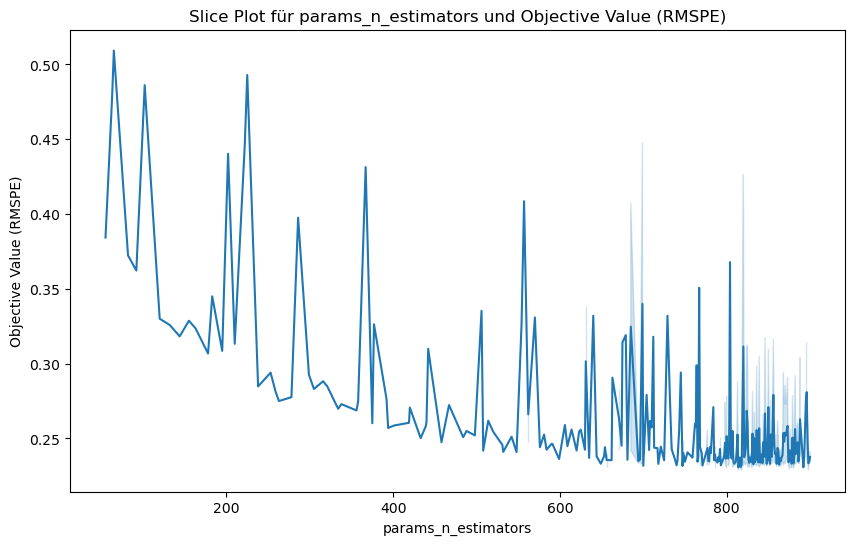

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda

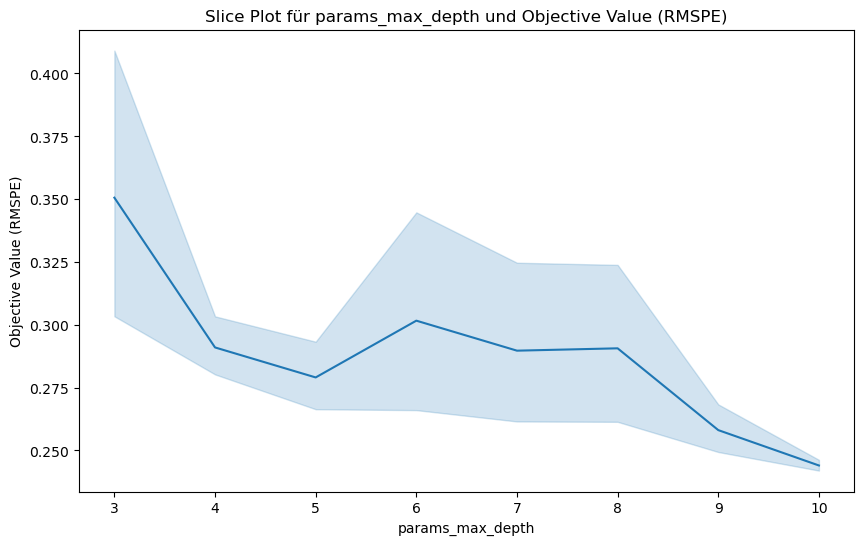

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda

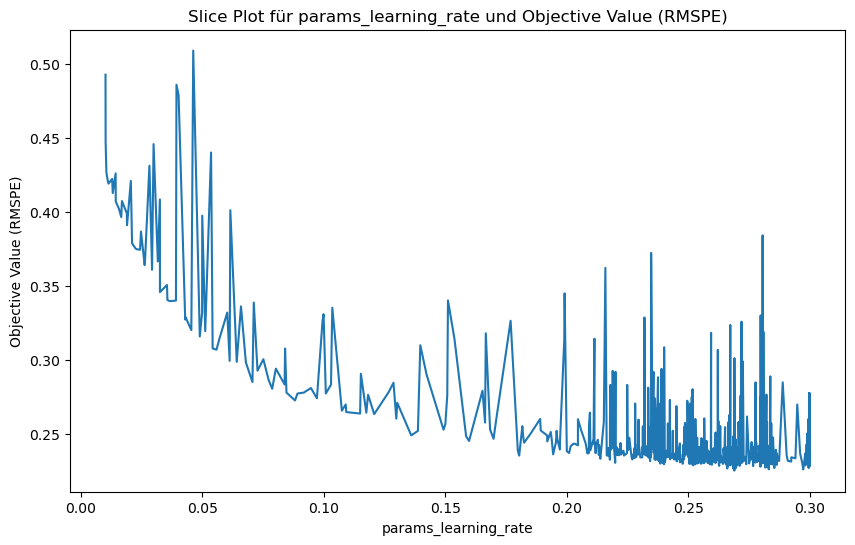

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda

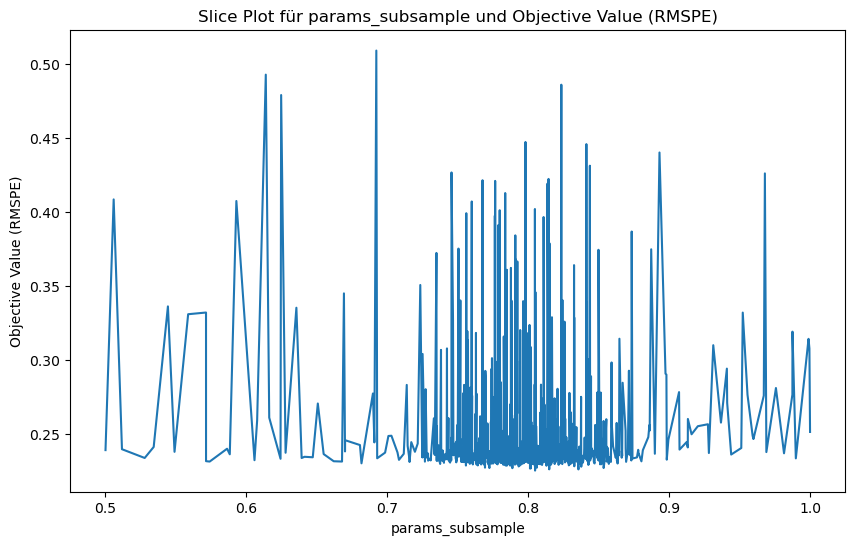

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda

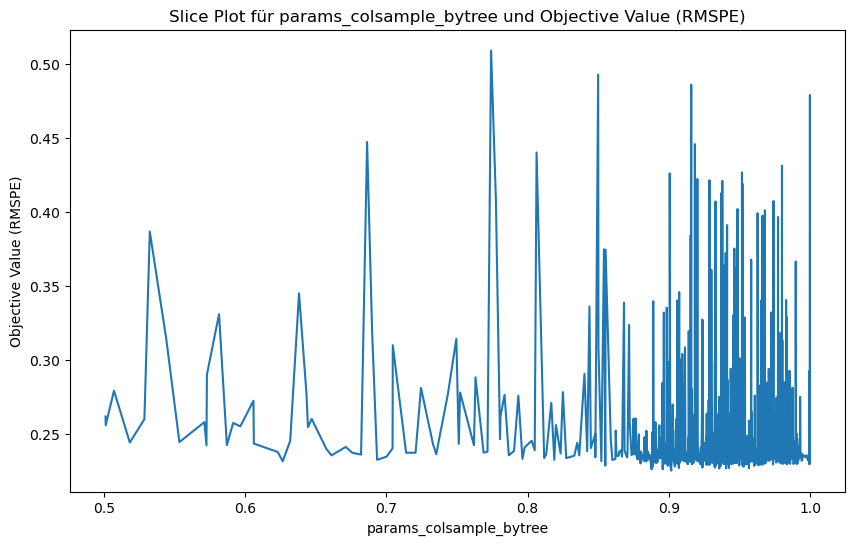

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/1920635020.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda

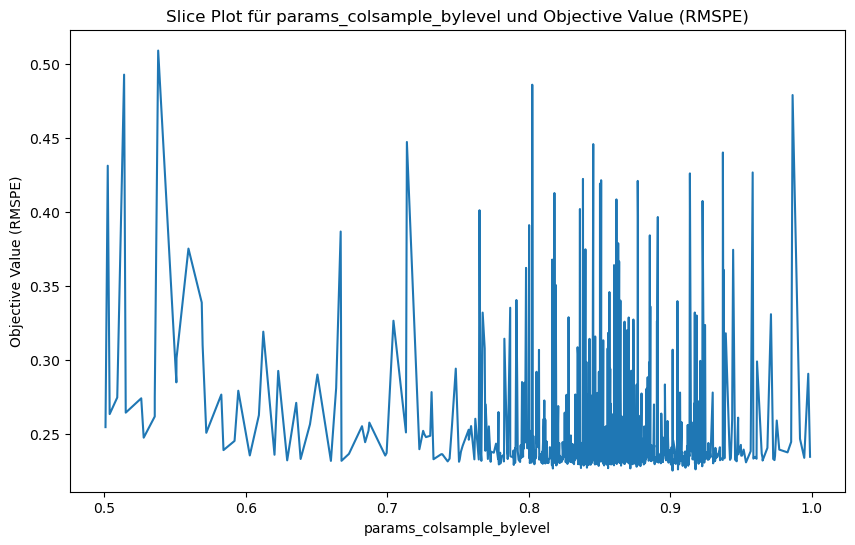

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Liste der zu plottenden Hyperparameter
hyperparameters = ['params_n_estimators', 'params_max_depth', 'params_learning_rate', 
                   'params_subsample', 'params_colsample_bytree', 'params_colsample_bylevel']

# Schleife durch jeden Hyperparameter
for param in hyperparameters:
    # Wähle den aktuellen Hyperparameter und die Zielmetrik (Objective Value) aus
    df = trials[[param, 'value']]

    # Ersetze unendliche Werte (inf) durch NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Entferne Zeilen mit NaN-Werten, da diese nicht geplottet werden können
    df.dropna(inplace=True)

    # Erstelle den Slice Plot für den aktuellen Hyperparameter
    plt.figure(figsize=(10, 6))  # Optional: Größe des Diagramms festlegen
    sns.lineplot(data=df, x=param, y='value')
    
    # Setze den Titel und Achsenbeschriftungen
    plt.title(f'Slice Plot für {param} und Objective Value (RMSPE)')
    plt.xlabel(param)
    plt.ylabel('Objective Value (RMSPE)')
    
    # Zeige das Diagramm an
    plt.show()

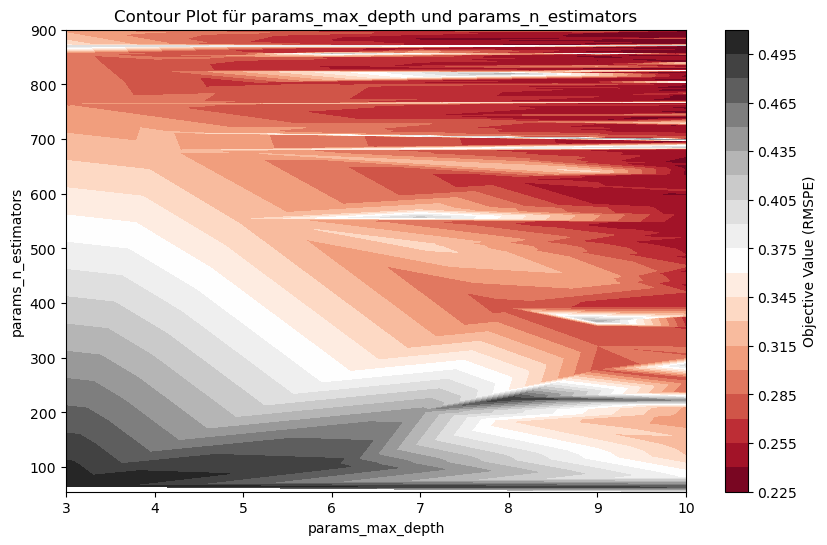

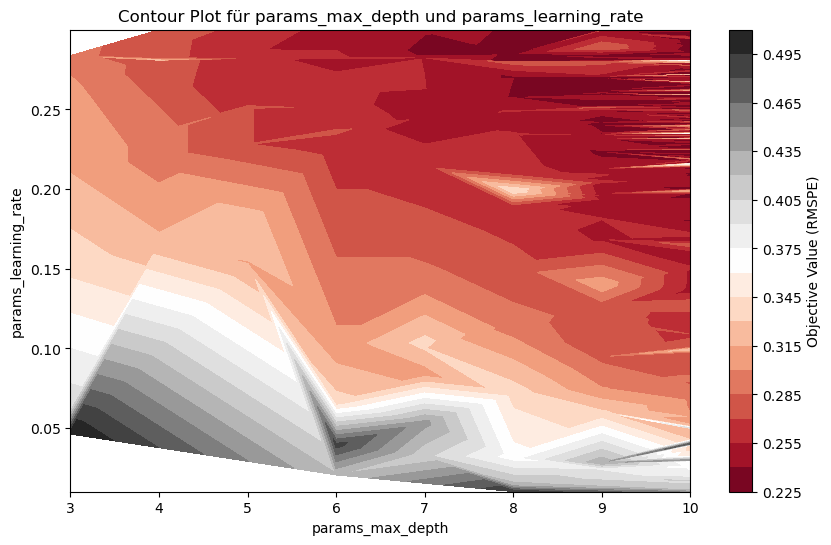

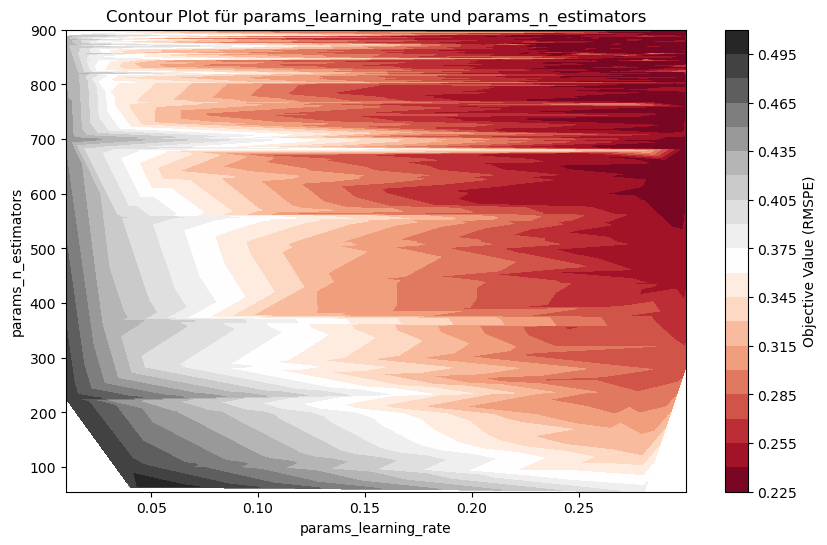

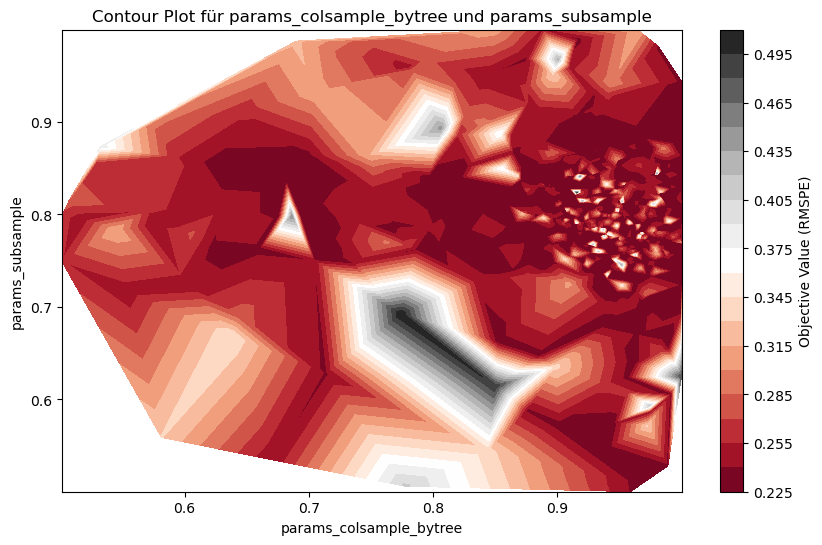

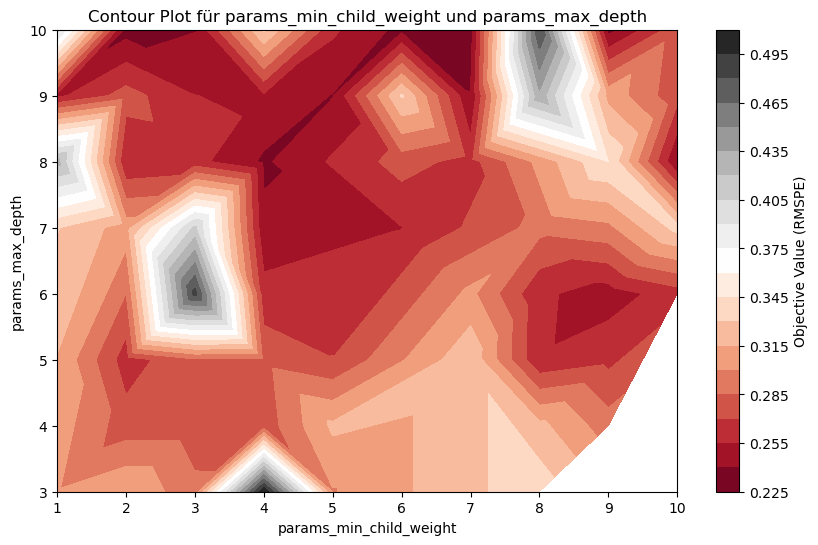

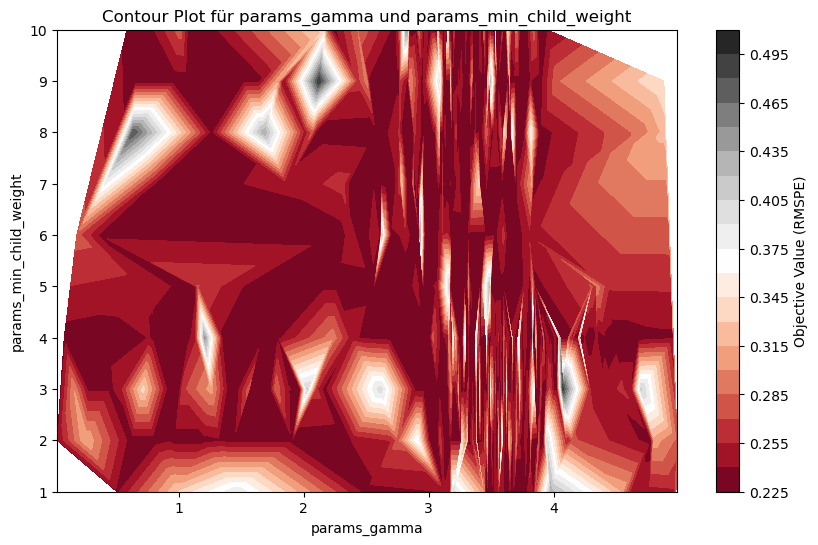

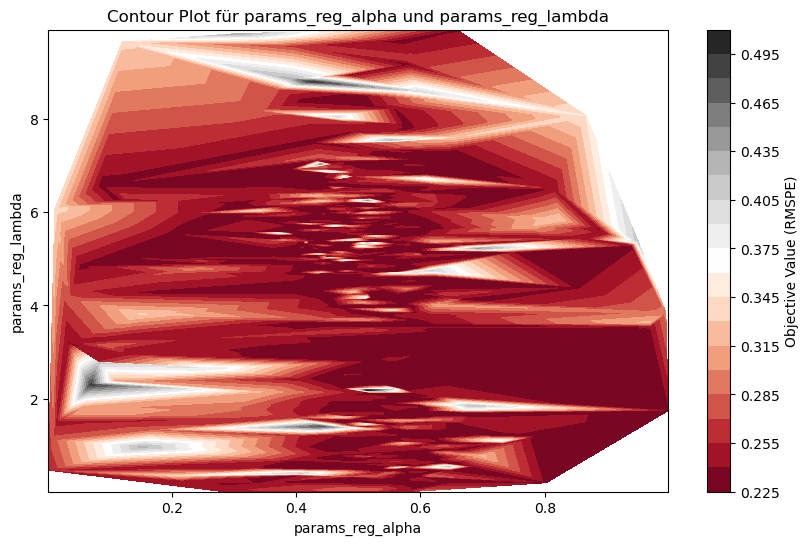

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Liste der möglichen Parameterpaare, die du analysieren möchtest
parameter_pairs = [
    ('params_max_depth', 'params_n_estimators'),
    ('params_max_depth', 'params_learning_rate'),
    ('params_learning_rate', 'params_n_estimators'),
    ('params_colsample_bytree', 'params_subsample'),
    ('params_min_child_weight', 'params_max_depth'),
    ('params_gamma', 'params_min_child_weight'),
    ('params_reg_alpha', 'params_reg_lambda')
]

# Schleife durch jedes Parameterpaar und erstelle einen Contour Plot
for param_x, param_y in parameter_pairs:
    # Wähle zwei Hyperparameter und die Zielmetrik (RMSPE)
    df = trials[[param_x, param_y, 'value']].dropna()  # Entferne NaN-Werte

    # Extrahiere die Werte für die Achsen und die Zielmetrik
    x = df[param_x].values
    y = df[param_y].values
    z = df['value'].values

    # Erstelle den Contour Plot
    plt.figure(figsize=(10, 6))
    plt.tricontourf(x, y, z, 20, cmap='RdGy')
    plt.colorbar(label='Objective Value (RMSPE)')
    
    # Achsenbeschriftungen und Titel setzen
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f'Contour Plot für {param_x} und {param_y}')
    
    # Zeige das Diagramm an
    plt.show()

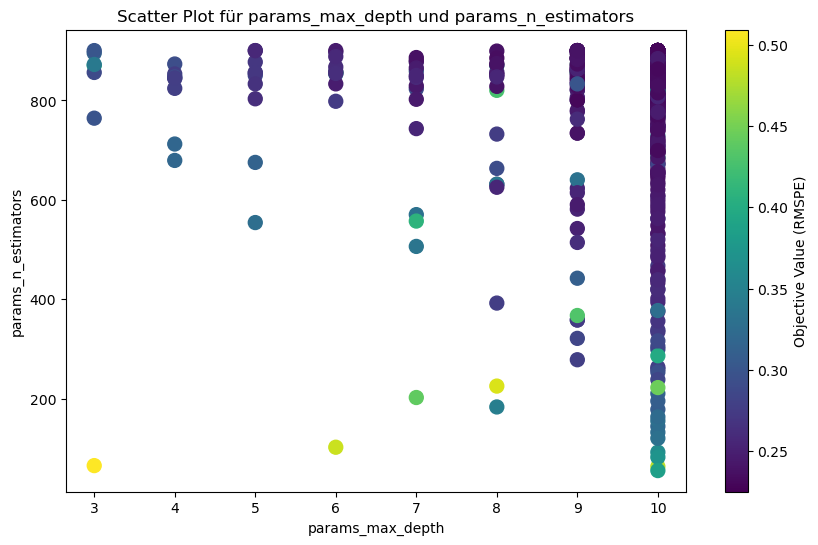

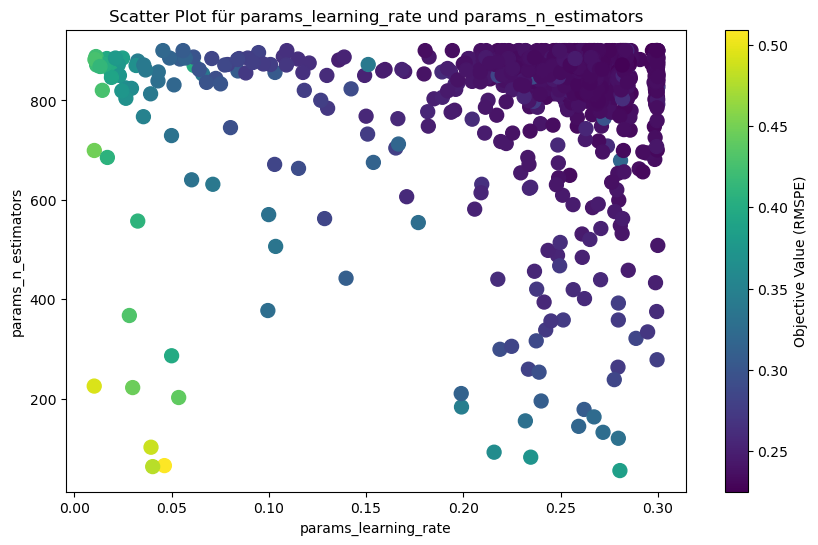

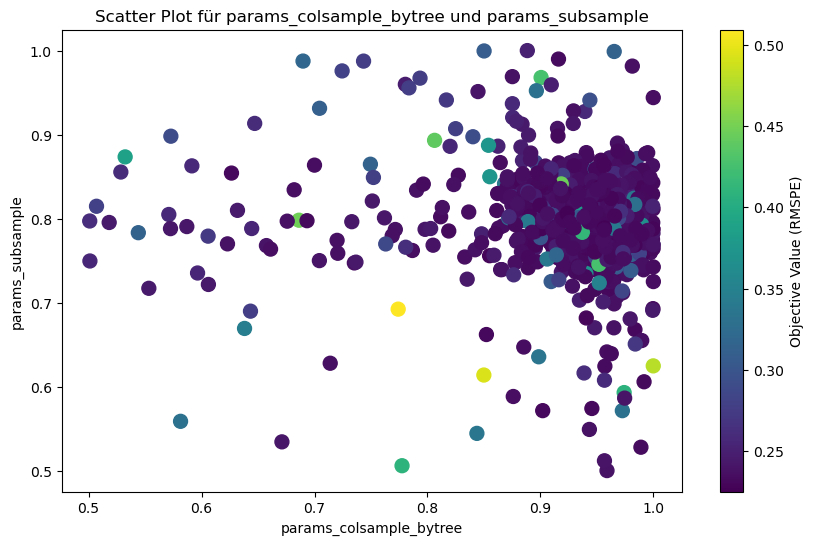

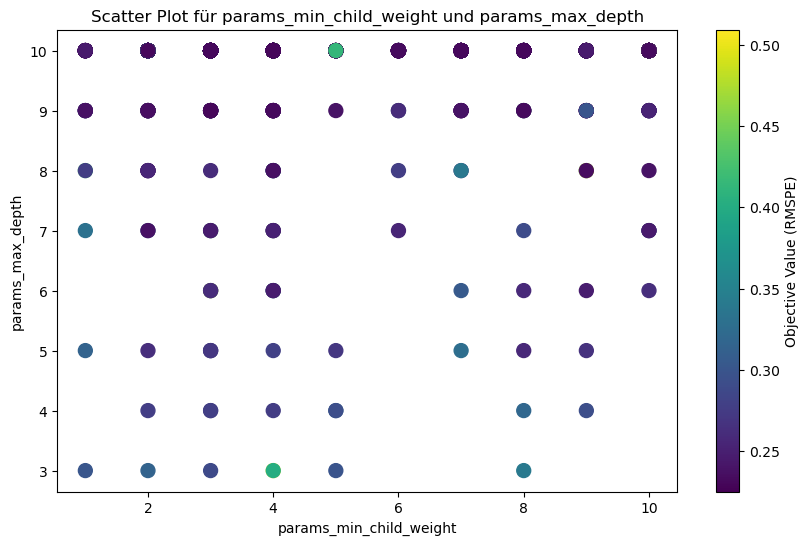

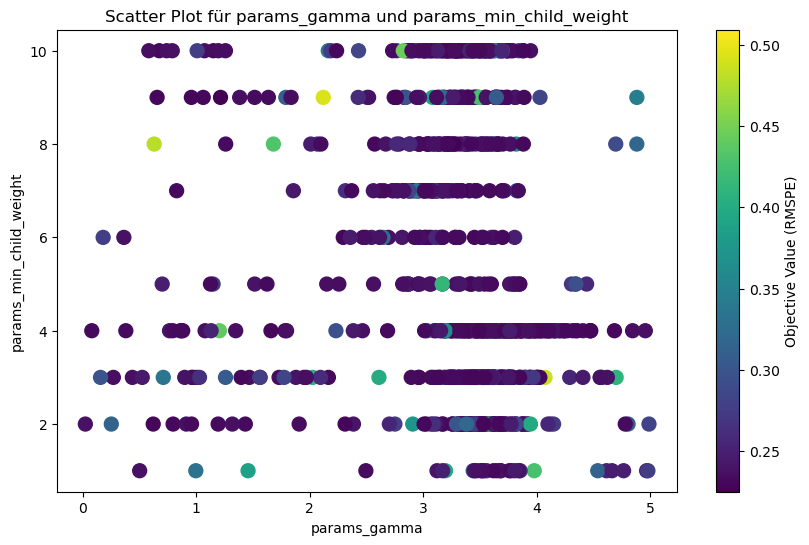

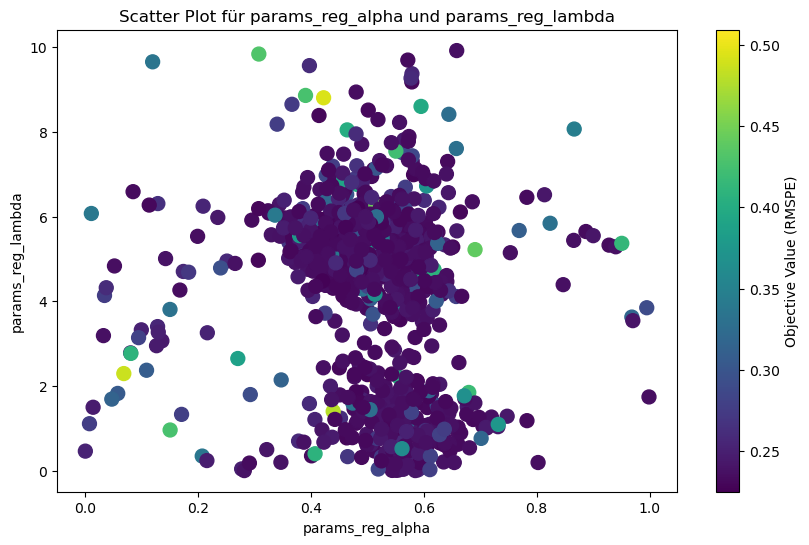

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Liste der möglichen Parameterpaare, die du analysieren möchtest
parameter_pairs = [
    ('params_max_depth', 'params_n_estimators'),
    ('params_learning_rate', 'params_n_estimators'),
    ('params_colsample_bytree', 'params_subsample'),
    ('params_min_child_weight', 'params_max_depth'),
    ('params_gamma', 'params_min_child_weight'),
    ('params_reg_alpha', 'params_reg_lambda')
]

# Schleife durch jedes Parameterpaar und erstelle einen Scatter Plot
for param_x, param_y in parameter_pairs:
    # Wähle zwei Hyperparameter und die Zielmetrik (RMSPE)
    df = trials[[param_x, param_y, 'value']].dropna()  # Entferne NaN-Werte

    # Extrahiere die Werte für die Achsen und die Zielmetrik
    x = df[param_x].values
    y = df[param_y].values
    z = df['value'].values

    # Erstelle den Scatter Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x, y, c=z, cmap='viridis', s=100)
    plt.colorbar(scatter, label='Objective Value (RMSPE)')
    
    # Achsenbeschriftungen und Titel setzen
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.title(f'Scatter Plot für {param_x} und {param_y}')
    
    # Zeige das Diagramm an
    plt.show()

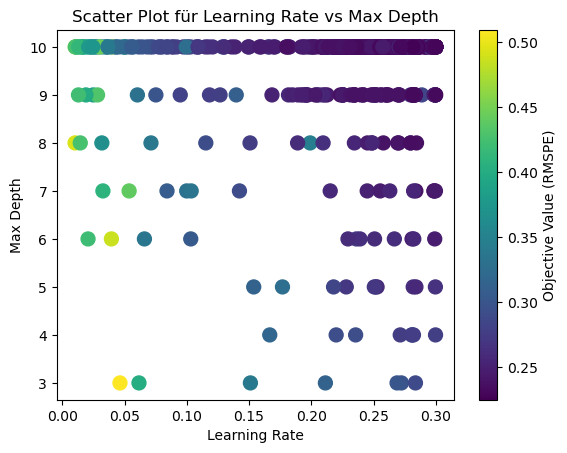

In [88]:
# Wähle zwei Hyperparameter und die Zielmetrik aus
df = trials[['params_learning_rate', 'params_max_depth', 'value']]

# Erstelle den Scatter Plot
plt.scatter(df['params_learning_rate'], df['params_max_depth'], c=df['value'], cmap='viridis', s=100)
plt.colorbar(label='Objective Value (RMSPE)')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('Scatter Plot für Learning Rate vs Max Depth')
plt.show()

## Finales Modell trainieren

### Beste Hyperparameter

In [33]:
best_params = {
    'n_estimators': 900,
    'max_depth': 10,
    'min_child_weight': 8,
    'learning_rate': 0.2688555222102847,
    'subsample': 0.8049082697078238,
    'colsample_bytree': 0.9017085061339981,
    'colsample_bylevel':  0.9016501277919797,
    'gamma': 3.5191228580676372,
    'reg_alpha': 0.4301285235544994,
    'reg_lambda': 5.1451545907615355
}

In [35]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])


### Initialisierung der Pipeline

In [36]:
# Pipeline für die Modellierung
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('model', xgboost.XGBRegressor(**best_params, random_state = 42))  # Schritt 3: Modellierung
])

### Training

In [37]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortm...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.2688555222102847, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=8, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=900, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

### Kreuzvalidierung

In [38]:
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

mean_rmspe = np.mean(cv_scores)

print(mean_rmspe)

-0.22514420173203087


### Test

In [39]:
y_pred = pipeline_xgb.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
print(test_rmspe)

0.16749093573181503


### Überprüfung Overfitting

In [114]:
# Vorhersagen auf den Trainingsdaten
y_train_pred = pipeline_xgb.predict(X_train)

# Vorhersagen auf den Testdaten
y_test_pred = pipeline_xgb.predict(X_test)

# Berechne den RMSPE auf den Trainings- und Testdaten
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

print(f'Training RMSPE: {train_rmspe}')
print(f'Test RMSPE: {test_rmspe}')

Training RMSPE: 0.19228065542947473
Test RMSPE: 0.16749093573181503


In [68]:
# Konvertiere die 'Date'-Spalte in ein Datetime-Format
X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_3994/3485581300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = pd.to_datetime(X_test['Date'], errors='coerce')  # Konvertiere in Datetime, Fehler werden als NaT behandelt


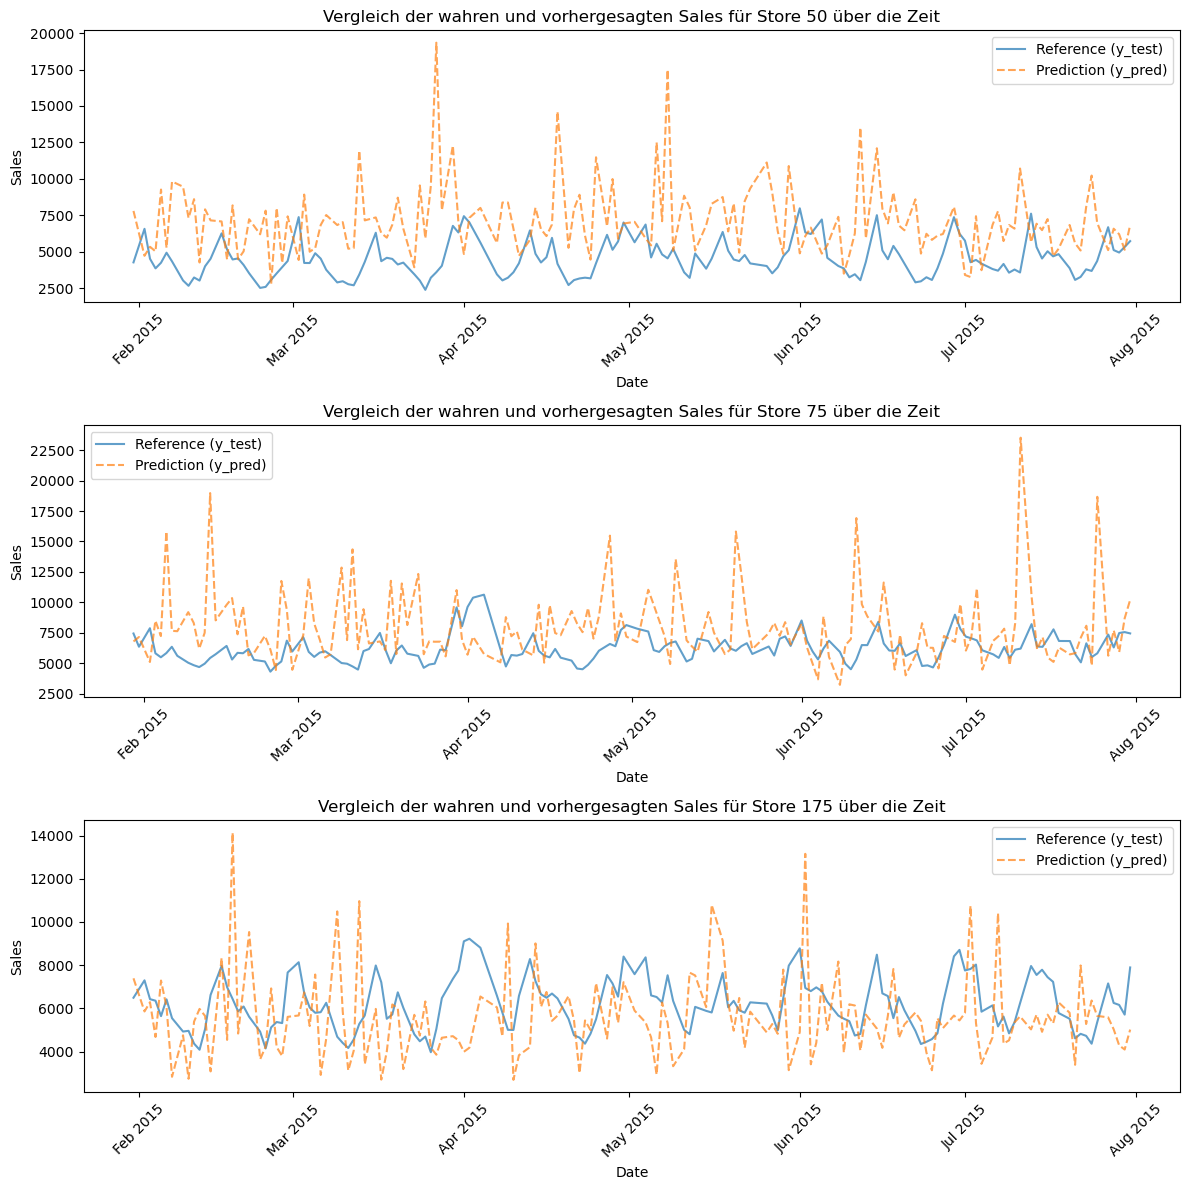

In [70]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Liste der Stores, die du visualisieren möchtest
store_list = [50, 75, 175]  # Beispiel: Stores 1, 2, 3

# Anzahl der Subplots festlegen
num_stores = len(store_list)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 4 * num_stores))

if num_stores == 1:
    axes = [axes]  # Falls nur ein Store, damit axes immer iterierbar ist

# Schleife über die verschiedenen Stores
for i, store in enumerate(store_list):
    # Filtern der Testdaten für den aktuellen Store
    store_test_data = X_test[X_test['Store'] == store]
    store_y_test = y_test[store_test_data.index]
    
    # Indizes herausfinden
    store_indices = store_test_data.index
    
    # Vorhersagen für diese Indizes extrahieren
    store_y_pred = y_pred[store_indices - X_test.index.min()]
    
    # Sortieren nach Datum
    store_test_data = store_test_data.sort_values('Date')
    store_y_test = store_y_test[store_test_data.index]
    store_y_pred = store_y_pred[np.argsort(store_test_data['Date'].values)]
    
    # Plotten für den aktuellen Store
    axes[i].plot(store_test_data['Date'], store_y_test, label='Reference (y_test)', linestyle='-', marker='', alpha=0.7)
    axes[i].plot(store_test_data['Date'], store_y_pred, label='Prediction (y_pred)', linestyle='--', marker='', alpha=0.7)
    
    # X-Achsen Formatierung: Nur einmal pro Monat anzeigen
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Monatliche Ticks
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Nur Monat und Jahr anzeigen
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Vergleich der wahren und vorhergesagten Sales für Store {store} über die Zeit')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)  # X-Achse drehen, um die Daten lesbar zu machen

# Layout anpassen, damit sich die Subplots nicht überlappen
plt.tight_layout()
plt.show()